In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
GOOGLE_COLAB = True

In [0]:
%reload_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import sys
if GOOGLE_COLAB:
    sys.path.append('drive/My Drive/yelp_sentiment_analysis')
else:
    sys.path.append('../')

from yelpsent import data
from yelpsent import features
from yelpsent import metrics
from yelpsent import visualization
from yelpsent import models

In [0]:
import importlib
def reload():
  importlib.reload(data)
  importlib.reload(features)
  importlib.reload(metrics)
  importlib.reload(visualization)
  importlib.reload(models)

# Load Dataset

In [0]:
if GOOGLE_COLAB:
    data_train, data_test = data.load_dataset("drive/My Drive/yelp_sentiment_analysis/data/yelp_train_balanced.json",
                                              "drive/My Drive/yelp_sentiment_analysis/data/yelp_test.json")
else:
    data_train, data_test = data.load_dataset("../data/yelp_train.json",
                                              "../data/yelp_test.json")

In [0]:
X_train = data_train['review'].tolist()
y_train = data_train['sentiment'].tolist()

In [0]:
X_test = data_test['review'].tolist()
y_test = data_test['sentiment'].tolist()

# Load DTMs

In [0]:
with open('drive/My Drive/yelp_sentiment_analysis/pickles/vectorizer.pickle', 'rb') as f:
    vectorizer = pickle.load(f)

with open('drive/My Drive/yelp_sentiment_analysis/pickles/X_train_dtm.pickle', 'rb') as f:
    X_train_dtm = pickle.load(f)

with open('drive/My Drive/yelp_sentiment_analysis/pickles/X_test_dtm.pickle', 'rb') as f:
    X_test_dtm = pickle.load(f)

# SVM

In [0]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [0]:
params

{'C': array([1.00000000e-05, 3.98107171e-05, 1.58489319e-04, 6.30957344e-04,
        2.51188643e-03, 1.00000000e-02])}

In [0]:
# Grid-search for C
params = {'C' : np.logspace(-5, -2, 6)}

gscv = GridSearchCV(LinearSVC(max_iter=1000),
                    params,
                    scoring='f1_macro',
                    cv=3,
                    verbose=1,
                    n_jobs=-1)

In [0]:
gscv.fit(X_train_dtm, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 3.98107171e-05, 1.58489319e-04, 6.30957344e-04,
       2.51188643e-03, 1.00000000e-02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=1)

In [0]:
print(gscv.best_params_)

{'C': 0.0025118864315095794}


In [0]:
model = LinearSVC(max_iter=1000,
                  C=0.0025118864315095794,
                  random_state=647)

In [0]:
%time model.fit(X_train_dtm, y_train)

CPU times: user 11.5 s, sys: 7.89 ms, total: 11.5 s
Wall time: 11.5 s


LinearSVC(C=0.0025118864315095794, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=647,
          tol=0.0001, verbose=0)

In [0]:
# with open('drive/My Drive/yelp_sentiment_analysis/models/svm.pickle', 'wb') as f:
#   pickle.dump(model, f)

with open('drive/My Drive/yelp_sentiment_analysis/models/svm.pickle', 'rb') as f:
  model = pickle.load(f)

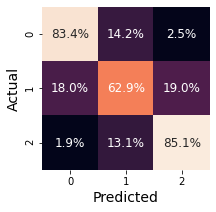

Macro F1 Scores: 
 Training: 0.883 
 Testing: 0.757




In [13]:
y_train_pred, y_test_pred, f1_train, f1_test =\
models.evaluate_pipeline(X_train = X_train_dtm,
                         y_train = y_train,
                         X_test = X_test_dtm,
                         y_test = y_test,
                         pipeline = model)

print("Macro F1 Scores: \n Training: {0:.3f} \n Testing: {1:.3f}\n\n".format(f1_train, f1_test))

In [0]:
feature_to_coefs = {
    word: coef for word, coef in zip(
        vectorizer.get_feature_names(),
        model.coef_.transpose()
    )
}

In [0]:
most_discriminatives = sorted(feature_to_coefs.items(),
                              key=lambda x: np.std(x[1]),
                              reverse=True)

least_discriminatives = sorted(feature_to_coefs.items(),
                               key=lambda x: np.std(x[1]),
                               reverse=False)

most_negative = sorted(feature_to_coefs.items(),
                       key=lambda x: x[1][0],
                       reverse=True)

most_neutral = sorted(feature_to_coefs.items(),
                      key=lambda x: x[1][1],
                      reverse=True)

most_positive = sorted(feature_to_coefs.items(),
                       key=lambda x: x[1][2],
                       reverse=True)

In [0]:
mosts = {"Most Discriminative":most_discriminatives,
         "Least Discriminative":least_discriminatives,
         "Most Negative":most_negative,
         "Most Neutral":most_neutral,
         "Most Positive":most_positive}

In [22]:
for name, lst in mosts.items():
  print("\n{name}:".format(name=name))
  for i in lst[:10]:
    feature = i[0]
    coefs = i[1]
    coefs = np.round(coefs, decimals=3)
    print('|'.join([feature, str(coefs[0]), str(coefs[1]), str(coefs[2])]))


Most Discriminative:
3 star|-0.48|0.584|-0.318
three star|-0.362|0.529|-0.244
3 5|-0.273|0.463|-0.371
horrible|0.305|-0.145|-0.275
worst|0.314|-0.153|-0.251
2 star|0.325|-0.187|-0.19
delicious|-0.268|-0.102|0.295
terrible|0.271|-0.109|-0.291
two star|0.3|-0.203|-0.157
a ok|-0.172|0.299|-0.19

Least Discriminative:
away unless|0.0|0.0|0.0
eastern fried|0.0|0.0|0.0
highly discourage|0.0|0.0|0.0
my disgust|0.0|0.0|0.0
once apologize|0.0|0.0|0.0
place waste|0.0|0.0|0.0
situation which|0.0|0.0|0.0
terrible din|0.0|0.0|0.0
this joke|0.0|0.0|0.0
worst dining|0.0|0.0|0.0

Most Negative:
2 star|0.325|-0.187|-0.19
worst|0.314|-0.153|-0.251
horrible|0.305|-0.145|-0.275
two star|0.3|-0.203|-0.157
terrible|0.271|-0.109|-0.291
awful|0.268|-0.127|-0.212
tasteless|0.264|-0.14|-0.185
disappointing|0.262|-0.088|-0.24
bland|0.257|-0.097|-0.227
2 5|0.255|-0.054|-0.21

Most Neutral:
3 star|-0.48|0.584|-0.318
three star|-0.362|0.529|-0.244
3 5|-0.273|0.463|-0.371
a ok|-0.172|0.299|-0.19
not bad|-0.285|0.23